### NY Taxi Train Amazon Forecast with Weather Index

Our goal is to predict the number of NY City yellow taxi pickups in the next 7 days for each of 260 pickup zones.  <br>

To do this, we will use Amazon Forecast with 1 hour frequency and 7 day forecast horizon.  For the demo, we'll use 8 months of historical data for training, and we will use the built-in Weather Index feature of Amazon Forecast that reads in 14-day weather predictions as related data. <br>

<ul>
<li>Original data source for all open data from 2008-now:  <a href="https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page", target="_blank"> https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page</a> </li>
    <li>AWS-hosted public location:  <a href="https://registry.opendata.aws/nyc-tlc-trip-records-pds/", target="_blank">https://registry.opendata.aws/nyc-tlc-trip-records-pds/ </a> </li>
    <li>AWS managed weather data ingestion as a service that is bundled with Amazon Forecast data source <a href="https://www.ecmwf.int/en/forecasts", target="_blank">European Centre for Medium-Range Weather Forecasts </a>, aggregated by location and by hour.  Initially only for USA and Europe, but depending on demand, possibly in the future for other global regions. </li>
    </ul>

<b>This notebook covers inputting data into Amazon Forecast and training a model using the Weather Index.</b>  Amazon Forecast Notebooks are useful to see the overall Forecast API workflow. In this notebook, the Import Data and Train Predictor steps are changed for the Weather Index.  Otherwise, the API steps are exactly the same as in other notebooks, see for example:<br>
<li><a href="https://github.com/aws-samples/amazon-forecast-samples/blob/master/notebooks/advanced/Incorporating_Related_Time_Series_dataset_to_your_Predictor/Incorporating_Related_Time_Series_dataset_to_your_Predictor.ipynb", target="_blank">Creating Related Time Series notebook for a good overview of the non-Weather Forecast API steps.</a></li>

Once you've run through a notebook once or twice, you'll probably decide you don't want to call Forecast APIs anymore via notebook!  More efficient use of your time is to call APIs from automation.  When you're ready, take a look at our Solution that uses AWS Lambda Step Functions and Amazon Quicksight for visualization to integrate Amazon Forecast with upstream/downstream Data applications.
<ul>
    <li><a href="https://aws.amazon.com/solutions/implementations/improving-forecast-accuracy-with-machine-learning", target='_blank'>Amazon Forecast Automation Solution</a></li>
    </ul>

<img src="images/forecast_steps_overview.png" width="98%">

<br>


# Table of Contents

* Step 0: [Setting up](#setup)
* Step 1: [Read raw data and visualize](#read)
* Step 2: [Importing the Data into Forecast](#import)
 * Step 2a: [Creating a Dataset Group](#create)
 * Step 2b: [Creating a Target Dataset](#target)
 * Step 2c: [Update the Dataset Group](#update)
 * Step 2d: [Creating a Target Time Series Dataset Import Job](#targetImport)
* Step 3: [Train a predictor using DeepAR+](#DeepAR)
* Step 4: [Export backtest files](#backtest)
* Step 5: [Visualize accuracy of predictors with and without weather](#visualize)
* Step 6: [Cleaning up your Resources](#cleanup)


#  First let us setup Amazon Forecast<a class="anchor" id="setup">

This section sets up the permissions and relevant endpoints.

In [1]:
import sys
import os
import shutil

import pandas as pd
print('pandas: {}'.format(pd.__version__))
import numpy as np
print('numpy: {}'.format(np.__version__))

# get region from boto3
import boto3
REGION = boto3.Session().region_name

# importing forecast notebook utility from notebooks/common directory
sys.path.insert( 0, os.path.abspath("../../common") )
import util

import matplotlib.pyplot as plt
%matplotlib inline 
plt.rcParams['figure.figsize'] = (15.0, 5.0)

pandas: 1.0.5
numpy: 1.19.1


In [2]:
#########
# Function to concat .part files in predictor backtest file export folder
#########

def read_backtest_predictions(BUCKET_NAME, s3_path):
    """Read predictor backtest predictions export files
       Inputs: 
           BUCKET_NAME = S3 bucket name
           s3_path = S3 path to Predictor.part files
                         , everything after "s3://BUCKET_NAME/" in S3 URI path to your .part files
       Return: Pandas dataframe with all .part files concatenated row-wise
    """
    # set s3 path
    s3 = boto3.resource('s3')
    s3_bucket = boto3.resource('s3').Bucket(BUCKET_NAME)
    s3_depth = s3_path.split("/")
    s3_depth = len(s3_depth) - 1
    
    # set local path
    local_write_path = "backtest_exports"
    if (os.path.exists(local_write_path) and os.path.isdir(local_write_path)):
        shutil.rmtree('backtest_exports')
    if not(os.path.exists(local_write_path) and os.path.isdir(local_write_path)):
        os.makedirs(local_write_path)
    
    # concat part files
    part_filename = ""
    part_files = list(s3_bucket.objects.filter(Prefix=s3_path))
    print(f"Number .part files found: {len(part_files)}")
    for file in part_files:
        # There will be a collection of CSVs if the forecast is large, modify this to go get them all
        if "csv" in file.key:
            part_filename = file.key.split('/')[s3_depth]
            window_object = s3.Object(BUCKET_NAME, file.key)
            file_size = window_object.content_length
            if file_size > 0:
                s3.Bucket(BUCKET_NAME).download_file(file.key, local_write_path+"/"+part_filename)
        
    # Read from local dir and combine all the part files
    temp_dfs = []
    for entry in os.listdir(local_write_path):
        if os.path.isfile(os.path.join(local_write_path, entry)):
            df = pd.read_csv(os.path.join(local_write_path, entry), index_col=None, header=0)
            temp_dfs.append(df)

    # Return assembled .part files as pandas Dataframe
    fcst_df = pd.concat(temp_dfs, axis=0, ignore_index=True, sort=False)
    return fcst_df


#########
# Functions to classify items as "top movers" or not
#########

def get_velocity_per_item(df, timestamp_col, item_id_col="item_id"):
    """Calculate item velocity as item demand per hour.  
    """
    df[timestamp_col] = pd.to_datetime(df[timestamp_col], format='%Y-%m-%d %H:%M:%S')
    
    max_time_df = df.groupby([item_id_col], as_index=False).max()[[item_id_col, timestamp_col]]
    max_time_df.columns = [item_id_col, 'max_time']
    
    min_time_df = df.groupby([item_id_col], as_index=False).min()[[item_id_col, timestamp_col]]
    min_time_df.columns = [item_id_col, 'min_time']
    
    df = df.merge(right=max_time_df, on=item_id_col)
    df = df.merge(right=min_time_df, on=item_id_col)
    
    df['time_span'] = df['max_time'] - df['min_time']
    df['time_span'] = df['time_span'].apply(lambda x: x.seconds / 3600 + 1) # add 1 to include start datetime and end datetime
    df = df.groupby([item_id_col], as_index=False).agg({'time_span':'mean', 'target_value':'sum'})
    df['velocity'] = df['target_value'] / df['time_span']
    return df


def get_top_moving_items(gt_df
                                   , timestamp_col
                                   , target_value_col
                                   , item_id_col="item_id"):
    """Calculate mean velocity over all items as "criteria".
       Assign each item into category "top" or not depending on whether its velocity > criteria.
    """
    gt_df_velocity = gt_df[[item_id_col, timestamp_col, target_value_col]].copy().reset_index(drop=True)
    gt_df_velocity = get_velocity_per_item(gt_df_velocity, timestamp_col, item_id_col)
    criteria = gt_df_velocity['velocity'].mean()
    gt_df_velocity['top_moving'] = gt_df_velocity['velocity'] > criteria
    print('average velocity of all items:', criteria)
    
    top_moving_items = gt_df_velocity[gt_df_velocity['top_moving'] == True][item_id_col].to_list()
    slow_moving_items = gt_df_velocity[gt_df_velocity['top_moving'] == False][item_id_col].to_list()
    return top_moving_items, slow_moving_items


###########
# Functions to calculate metrics
###########

def truncate_negatives_to_zero(the_df, target_value_col, quantile_cols):
    """In case you are expecting positive numbers for actuals and predictions,
       round negative values up to zero.
       
       Be careful that this is acceptable treatment of negatives for your use case.
    """
    
    df = the_df.copy()
    
    for q in quantile_cols:
        num_neg_predictions = df[q].lt(0).sum()
        print(f"Num negative {q} predictors: {num_neg_predictions}")

        # replace
        df[q] = df[q].mask(df[q] < 0, 0)

        # check you did the right thing
        num_neg_predictions = df[q].lt(0).sum()
        print(f"Num negative {q} predictors: {num_neg_predictions}")

    # truncate negative actuals
    num_neg_actuals = df[target_value_col].lt(0).sum()
    print(f"Num negative actuals: {num_neg_actuals}")

    # replace
    df[target_value_col] = df[target_value_col].mask(df[target_value_col] < 0, 0)

    # check you did the right thing
    num_neg_actuals = df[target_value_col].lt(0).sum()
    print(f"Num negative actuals: {num_neg_actuals}")
    
    return df


def calc_quantile_loss(actual, pred, quantile):
    """Calculate weighted quantile loss for a specific quantile and window
       Input: single numbers for actual and forecast
       Output:  wql = floating point number
    """
    denom = sum(np.abs(actual))
    num = sum([(1-quantile) * abs(y_hat-y) if y_hat > y
               else quantile * abs(y_hat-y) for y_hat, y in zip(pred, actual)])
    if denom != 0:
        return 2 * num / denom
    else:
        return None



Configure the S3 bucket name and region name for this lesson.

- If you don't have an S3 bucket, create it first on S3.
- Although we have set the region to us-west-2 as a default value below, you can choose any of the regions that the service is available in.

In [3]:
## Get user inputs for S3 bucket name and region

default_bucket = "taxi-demo"  #default taxi-demo
bucket_name = input("S3 bucket name [enter to accept default]: ") or default_bucket
default_region = REGION
REGION = input(f"region [enter to accept default]: {default_region} ") or default_region 

S3 bucket name [enter to accept default]: christy-open-data-analytics-taxi-trips
region [enter to accept default]: us-east-1 


In [4]:

# Connect API session
session = boto3.Session(region_name=REGION) 
forecast = session.client(service_name='forecast') 
#forecast_query = session.client(service_name='forecastquery') #not used in this notebook


In [5]:
# Create the role to provide to Amazon Forecast.
role_name = "ForecastNotebookRole-Weather"
print(f"Creating Role {role_name} ...")
default_role = util.get_or_create_iam_role( role_name = role_name )
role_arn = default_role

## echo user inputs without account
print(f"Success! Created role arn = {role_arn.split('/')[1]}")

Success! Created role arn = ForecastNotebookRole


In [ ]:
# check you did the right thing
forecast.list_predictors()

# Step 1: Read raw data and visualize<a class="anchor" id="read">

In [7]:
df_raw = pd.read_csv("data/TTS.csv")
print(df_raw.shape)

# correct data types
df_raw.item_id = df_raw.item_id.astype(str)
df_raw.timestamp = pd.to_datetime(df_raw.timestamp
                                                 , format="%Y-%m-%d %H:%M:%S", errors='coerce')
print(df_raw.dtypes)

# check size and number items
print(f"num items:  {df_raw.item_id.nunique()}")
start_time = df_raw.timestamp.min()
end_time = df_raw.timestamp.max()
print(f"start time: {start_time}")
print(f"end time: {end_time}")

(648414, 4)
timestamp       datetime64[ns]
item_id                 object
actual_value             int64
location                object
dtype: object
num items:  260
start time: 2019-07-01 00:00:00
end time: 2020-02-29 23:00:00


Let us plot overall time series first.

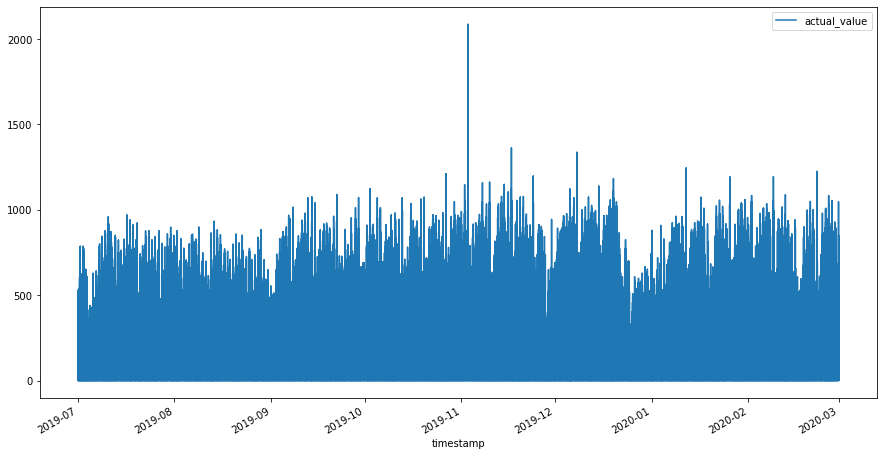

In [8]:
df_raw.plot(x='timestamp', y='actual_value', figsize=(15, 8))

# hmm, according to news, there was a cold snap and tornado on Nov 3rd:
# https://www.nbcnewyork.com/news/local/overnight-temperatures-to-dip-into-30s-snow-potential-friday/2084847/
# https://newyork.cbslocal.com/2019/11/03/national-weather-service-confirmed-tornado-new-jersey/

Now, let's drill down into a few time series

In [9]:
df_raw.loc[(df_raw.actual_value >= 1400), :]

,timestamp,item_id,actual_value,location
342843,2019-11-03 01:00:00,79,2085,40.8_-74.0
342876,2019-11-03 01:00:00,148,1710,40.8_-74.0


In [11]:
# out of curiosity, we can lookup locations 79 and 148 

locations = pd.read_csv("data/taxi_zones.csv")
locations.LocationID = locations.LocationID.astype(str)
locations.loc[(locations.LocationID.isin(['141', '151', '79', '148'])), :]

,X,Y,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough
78,-73.985214,40.727944,79,0.042625,0.000108,East Village,79,Manhattan
140,-73.959713,40.766839,141,0.041514,0.000077,Lenox Hill West,141,Manhattan
147,-73.990718,40.719212,148,0.039131,0.000070,Lower East Side,148,Manhattan
150,-73.967808,40.797866,151,0.054890,0.000129,Manhattan Valley,151,Manhattan


In [12]:
# assemble data for plotting actual values

random_items = ['141', '151', '79', '148']
df_plot = df_raw.loc[(df_raw.item_id.isin(random_items)), ['item_id', 'timestamp', 'actual_value']].copy()
df_plot = df_plot.merge(locations[['LocationID', 'zone']], how="left"
                        , left_on="item_id", right_on="LocationID")
df_plot.set_index('timestamp', inplace=True)
df_plot.head(2)

,item_id,actual_value,LocationID,zone
timestamp,,,,
2019-07-01,79,214,79,East Village
2019-07-01,141,46,141,Lenox Hill West


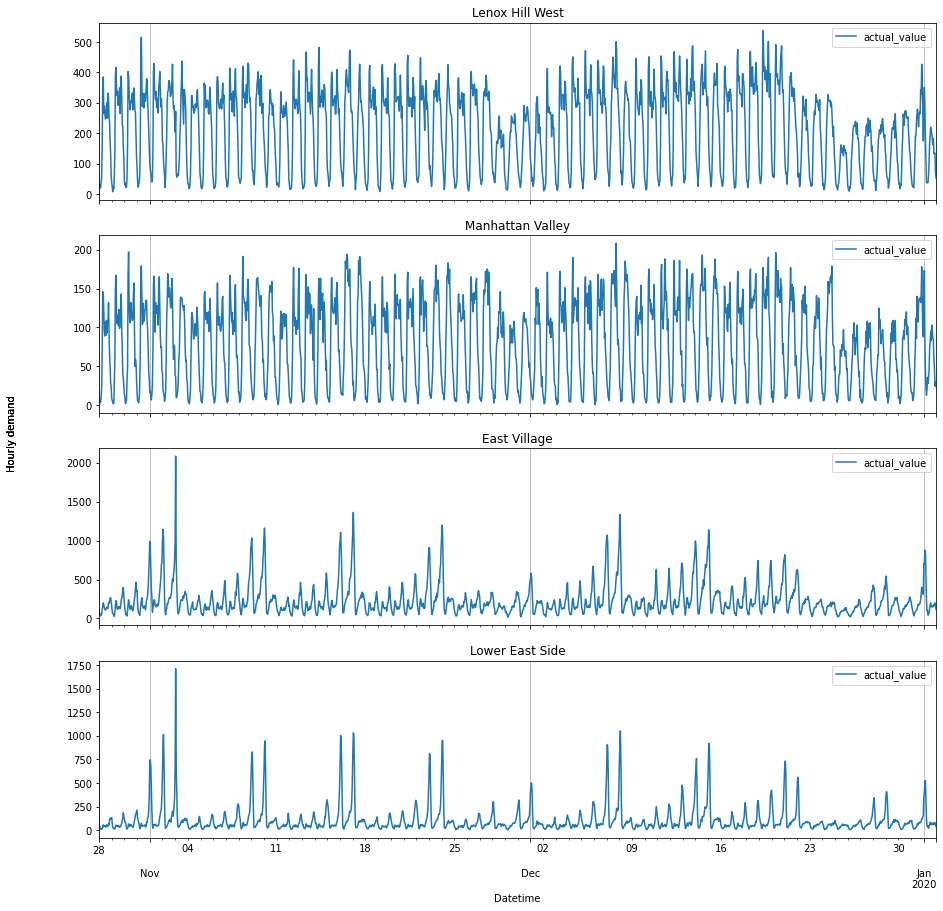

In [13]:
fig, axs = plt.subplots(len(random_items), 1, figsize=(15, 15), sharex=True)

# select backtest window range when there was a weather event
zoomed = df_plot.copy()
zoomed = zoomed.loc["2019-10-28":"2020-01-01"].copy()


for i in range(len(random_items)):
    
    item = random_items[i]
    zoomed2 = zoomed.loc[(zoomed['item_id']==item), :]
    zone = zoomed2.zone[0]

    zoomed2[['actual_value']].plot(ax=axs[i])
    
    axs[i].set_title(f"{zone}")  
    fig.text(0.04, 0.5, 'Hourly demand', va='center', rotation='vertical')
    
    # format the x ticks
    axs[i].set_xlabel("Datetime")   
        
    # format the grid
    axs[i].grid(False)
    axs[i].grid(which='major', axis='x')

plt.plot();

Above, we can see the regular effects of weekends.  For irregular effects, we can see Thanksgiving, Christmas, and New Years holidays.  Looking at the Nov 3rd spike, it appears another irregular effect was weather, since google search on Nov3, 2019 turns up no special events except a large winter storm.  

Conveniently, both weather and holidays are built into Amazon Forecast for you to choose if you think they are applicable to your use case and could improve your forecast accuracy. Amazon Forecast does the work of gathering the data, featurizing holidays and weather data, and loading into Related Time Series.  As long as forecast horizon is under 2 weeks away, we also take care of the overhead customers usually struggle with, keeping Related Time Series a forecast horizon ahead of the Target Time Series, since we use 14-day weather forecasts.  

For an intro to Amazon Forecast, see our 
<li><a href="https://docs.aws.amazon.com/forecast/latest/dg/weather.html", target="_blank">Documentation page.</a></li>

<br>
<br>

# Step 2. Importing the Data<a class="anchor" id="import">

Now we are ready to import the datasets into the Forecast service. As an example, a retailer normally records the transaction record such as 
<img src="images/target_time_series_columns.png" width="98%">
<br>
    
<b>In order to use Weather Index, you need to add to the above, a geolocation-type column.</b>  The geolocation-type column connects your location column with geolocations either through postal codes or with latitude_longitude and Timezone.  For more details, see:
<ul>
    <li><a href="https://docs.aws.amazon.com/forecast/latest/dg/weather.html#adding-geolocation", target="_blank">Link to documentation about geolocation</a></li>
        <li><a href="https://docs.aws.amazon.com/forecast/latest/dg/weather.html#specifying-timezones", target="_blank">Link to documentation about timezone</a></li>
<li><a href="./0. Optional - Preparing location data for Weather Index.ipynb", target="_blank">For an example, see our optional notebook preparing geodata</a></li>
    </ul>
    
<b>For an example of a geolocation column that uses Lat_Lon data, run the cell below and look at the Target Time Series included in the data folder of this notebook.</b>

In [12]:
## View the geolocation column "location"
df_raw.sample(5)

,timestamp,item_id,actual_value,location
478841,2019-12-24 17:00:00,112,1,40.8_-74.0
573138,2020-01-31 03:00:00,260,1,40.8_-74.0
121940,2019-08-13 08:00:00,41,39,40.8_-74.0
307597,2019-10-20 16:00:00,113,190,40.8_-74.0
184967,2019-09-05 15:00:00,87,93,40.8_-74.0


In [13]:
## Define a dataset group name and version number for naming purposes
project = "nyctaxi_demo"
idx = 1

## Step 2a. Creating a Dataset Group<a class="anchor" id="create">
First let's create a dataset group and then update it later to add our datasets.

Below, we specify key input data and forecast parameters

In [14]:
dataset_group = f"{project}_{idx}"
dataset_arns = []
create_dataset_group_response = forecast.create_dataset_group(
    Domain="CUSTOM",
    DatasetGroupName=dataset_group,
    DatasetArns=dataset_arns)

Below, we specify key input data and forecast parameters

In [15]:
freq = "H"
forecast_horizon = 168
timestamp_format = "yyyy-MM-dd HH:mm:ss"
delimiter = ','

In [16]:
print(f'Creating dataset group {dataset_group}')

Creating dataset group nyctaxi_demo_1


In [17]:
dataset_group_arn = create_dataset_group_response['DatasetGroupArn']

In [ ]:
forecast.describe_dataset_group(DatasetGroupArn=dataset_group_arn)

## Step 2b. Creating a Target Dataset<a class="anchor" id="target">
In this example, we will define a target time series. This is a required dataset to use the service.

Below we specify the target time series name af_demo_ts_4.

In [19]:
ts_dataset_name = f"{project}_tts_{idx}"
print(ts_dataset_name)

nyctaxi_demo_tts_1


Next, we specify the schema of our dataset below. Make sure the order of the attributes (columns) matches the raw data in the files. We follow the same three attribute format as the above example.

In [20]:
ts_schema_val = [{"AttributeName": "timestamp", "AttributeType": "timestamp"},
              {"AttributeName": "item_id", "AttributeType": "string"},
              {"AttributeName": "target_value", "AttributeType": "float"},
              {"AttributeName": "location", "AttributeType": "geolocation"} ]
ts_schema = {"Attributes": ts_schema_val}

In [21]:
print(f'Creating target dataset {ts_dataset_name}')

Creating target dataset nyctaxi_demo_tts_1


In [22]:
response = forecast.create_dataset(
    Domain="CUSTOM",
    DatasetType='TARGET_TIME_SERIES',
    DatasetName=ts_dataset_name,
    DataFrequency=freq,
    Schema=ts_schema
  )

In [23]:
ts_dataset_arn = response['DatasetArn']

In [ ]:
forecast.describe_dataset(DatasetArn=ts_dataset_arn)

## Step 2c. Updating the dataset group with the datasets we created<a class="anchor" id="update">
You can have multiple datasets under the same dataset group. Update it with the datasets we created before.

In [25]:
dataset_arns = []
dataset_arns.append(ts_dataset_arn)
forecast.update_dataset_group(DatasetGroupArn=dataset_group_arn, DatasetArns=dataset_arns)

{'ResponseMetadata': {'RequestId': '8ac197ad-b8b2-40af-84e8-60d3472ef7ff',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Tue, 08 Dec 2020 04:03:39 GMT',
   'x-amzn-requestid': '8ac197ad-b8b2-40af-84e8-60d3472ef7ff',
   'content-length': '2',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

In [ ]:
forecast.describe_dataset_group(DatasetGroupArn=dataset_group_arn)

## Step 2d. Creating a Target Time Series Dataset Import Job<a class="anchor" id="targetImport">
   
Below, we save the Target Time Series to your bucket on S3, since Amazon Forecast expects to be able to import the data from S3.

In [27]:
# Save FILE to S3
local_file = "data/TTS.csv"

# Save local file to S3
key = f"nyctaxi_demo/data/TTS.csv"
boto3.Session().resource('s3').Bucket(bucket_name).Object(key).upload_file(local_file)

In [ ]:
ts_s3_data_path = f"s3://{bucket_name}/nyctaxi_demo/data/TTS.csv"
print(ts_s3_data_path)

In [29]:
ts_dataset_import_job_response = forecast.create_dataset_import_job(
    DatasetImportJobName=dataset_group,
    DatasetArn=ts_dataset_arn,
    DataSource= {
        "S3Config" : {
            "Path": ts_s3_data_path,
            "RoleArn": role_arn
        } 
    },
    TimestampFormat=timestamp_format,
    GeolocationFormat="LAT_LONG",
    TimeZone="America/New_York"
    )


In [30]:
ts_dataset_import_job_arn=ts_dataset_import_job_response['DatasetImportJobArn']

In [31]:
status = util.wait(lambda: forecast.describe_dataset_import_job(DatasetImportJobArn=ts_dataset_import_job_arn))
assert status

CREATE_PENDING 
CREATE_IN_PROGRESS ..............................................
ACTIVE 


## Step 3. Train a predictor with related time series Weather and Holidays with DeepAR+ <a class="anchor" id="DeepAR">
    
Once the datasets are specified with the corresponding schema, Amazon Forecast will automatically aggregate all the relevant pieces of information for each item, such as holidays, weather, historical_sales or historical target_value, price, promotions, as well as categorical attributes, and generate the desired dataset. Next, one can choose an algorithm (forecasting model) and evaluate how well this particular algorithm works on this dataset. 

Amazon Forecast provides several state-of-the-art forecasting algorithms including classic forecasting methods such as: ETS, ARIMA, Prophet and deep learning approaches such as: DeepAR+ and CNN-QR.  
    
<b>For more details on algorithms see 
<br>
<li><a href="https://docs.aws.amazon.com/forecast/latest/dg/aws-forecast-choosing-recipes.html", target="_blank">Selecting an Amazon Forecast Algorithm </a></li>
    </b>
    
<br>
<b>
In addition to choosing an algorithm, you can also choose from among two built-in Supplementary Features - Holidays and Weather. </b>
    
<img src="images/built_in_RTS_Weather_alignment.png" width="80%">
<br>

<ul>
<li>Above left is how it looks in UI to select the Weather Index - you just toggle on the "Weather button".  </li>
<li>Above right is the concept of time-alignment with respect to Forecast Horizon of Target Time Series vs Related Time Series.  </li>
<li>Using Amazon Forecast's built-in Related Time Series - weather and holidays - we don't anymore have to manually create the related time series data, upload it to S3 and perform API tasks for the Related data.  </li>
<li>Using the built-in Supplementary Features - Amazon Forecast will automatically handle all the work of creating Holidays and/or Weather data featurization and performing correct time-alignment using Forecast Horizon. </li>
    </ul>
    
<i>Note: If you decide to create your own Related Time Series that utilizes geolocation, you will need to make sure you include the geolocation-type column in the Related Time Series data before you upload it to Amazon forecast.</i>

## Step 3a. Train a model without Weather but with Holidays


In [ ]:
# Quantiles for which you want forecasts generated
forecast_types = ["0.50", "0.60", "0.70"]

# Get these by running DeepAR+ 1x with HPO turned on
hyperparameters = {
    "context_length": "63",
    "epochs": "500",
    "learning_rate": "0.014138165570842774",
    "learning_rate_decay": "0.5",
    "likelihood": "student-t",
    "max_learning_rate_decays": "0",
    "num_averaged_models": "1",
    "num_cells": "40",
    "num_layers": "2",
    "prediction_length": str(forecast_horizon)
    }

# Use default missing data filling see: https://docs.aws.amazon.com/forecast/latest/dg/howitworks-missing-values.html
featurizations_no_weather = {"ForecastFrequency": freq }

# For weather index, need to specify which column contains geolocation 
# Use default missing data filling
featurizations_weather = {"ForecastFrequency": freq, 
                  "ForecastDimensions": ["location"] }

In [ ]:
algorithm_arn = 'arn:aws:forecast:::algorithm/'
algorithm = 'Deep_AR_Plus'
algorithm_arn_deep_ar_plus = algorithm_arn + algorithm
predictor_name_deepar_no_weather = f'no_weather_{algorithm.lower()}_{idx}'

print(f'[{predictor_name_deepar_no_weather}] Creating predictor {predictor_name_deepar_no_weather} ...')

In [ ]:
create_predictor_response = forecast.create_predictor(
      PredictorName=predictor_name_deepar_no_weather,
      AlgorithmArn=algorithm_arn_deep_ar_plus,
      ForecastHorizon=forecast_horizon,
      ForecastTypes=forecast_types,
      PerformAutoML=False,
      PerformHPO=False,
      TrainingParameters=hyperparameters,
      EvaluationParameters= {"NumberOfBacktestWindows": 3, 
                             "BackTestWindowOffset": forecast_horizon}, 
      InputDataConfig = { 
          "DatasetGroupArn": dataset_group_arn,
          "SupplementaryFeatures": [ 
             { 
                "Name": "holiday",
                "Value": "US"
             }]
       },
      FeaturizationConfig= featurizations_no_weather
     )

In [ ]:
predictor_arn_deepar_no_weather = create_predictor_response['PredictorArn']

In [ ]:
status = util.wait(lambda: forecast.describe_predictor(PredictorArn=predictor_arn_deepar_no_weather))
assert status

In [ ]:
forecast.describe_predictor(PredictorArn=predictor_arn_deepar_no_weather)

## Step 3b.  Train a model with Weather and Holidays

Note: To train an Amazon Forecast model with Weather Index, need to add the geolocation column as an extra "Forecast dimension".  In the UI it looks like this:   
<img src="images/forecast_dimension_location.png" width="60%">

Below, we've added geolocation as an extra "forecast dimension" in the FeaturizationConfig setting of the create_predictor API call.  

In [33]:

## REPEAT FOR REFERENCE, SAME SETTINGS USED FOR TRAINING NO-WEATHER MODEL

# Quantiles for which you want forecasts generated
forecast_types = ["0.50", "0.60", "0.70"]

# Get these by running DeepAR+ 1x with HPO turned on
hyperparameters = {
    "context_length": "63",
    "epochs": "500",
    "learning_rate": "0.014138165570842774",
    "learning_rate_decay": "0.5",
    "likelihood": "student-t",
    "max_learning_rate_decays": "0",
    "num_averaged_models": "1",
    "num_cells": "40",
    "num_layers": "2",
    "prediction_length": str(forecast_horizon)
    }

# Use default missing data filling see: https://docs.aws.amazon.com/forecast/latest/dg/howitworks-missing-values.html
featurizations_no_weather = {"ForecastFrequency": freq }

# For weather index, need to specify which column contains geolocation 
# Use default missing data filling
featurizations_weather = {"ForecastFrequency": freq, 
                  "ForecastDimensions": ["location"] }

In [34]:
algorithm_arn = 'arn:aws:forecast:::algorithm/'
algorithm = 'Deep_AR_Plus'
algorithm_arn_deep_ar_plus = algorithm_arn + algorithm
predictor_name_deepar_weather = f'weather_{algorithm.lower()}_{idx}'

print(f'[{predictor_name_deepar_weather}] Creating predictor {predictor_name_deepar_weather} ...')


[weather_deep_ar_plus_1] Creating predictor weather_deep_ar_plus_1 ...


In [35]:
create_predictor_response = forecast.create_predictor(
      PredictorName=predictor_name_deepar_weather,
      AlgorithmArn=algorithm_arn_deep_ar_plus,
      ForecastHorizon=forecast_horizon,
      ForecastTypes=forecast_types,
      PerformAutoML=False,
      PerformHPO=False,
      TrainingParameters=hyperparameters,
      EvaluationParameters= {"NumberOfBacktestWindows": 3, 
                             "BackTestWindowOffset": forecast_horizon}, 
      InputDataConfig = { 
          "DatasetGroupArn": dataset_group_arn,
          "SupplementaryFeatures": [ 
             { 
                "Name": "weather",
                "Value": "true"
             },
             { 
                "Name": "holiday",
                "Value": "US"
             }]
       },                                                                                                         
      FeaturizationConfig= featurizations_weather
     )

In [36]:
predictor_arn_deepar_weather = create_predictor_response['PredictorArn']

In [37]:
status = util.wait(lambda: forecast.describe_predictor(PredictorArn=predictor_arn_deepar_weather))
assert status

CREATE_PENDING 
CREATE_IN_PROGRESS ...................................................................................................................................................................................................................................................................................................................................
ACTIVE 


In [ ]:
forecast.describe_predictor(PredictorArn=predictor_arn_deepar_weather)

# Step 4. Export Backtest Predictions<a class="anchor" id="backtest">

After creating the predictors, we can export the Backtest Predictions to evaluate the performance of the algorithm, using custom item-level metrics if desired. "Backtesting" is a cross-validation technique for time series that uses multiple train/test splits that keep time order of the data. Using multiple train-test splits (i.e. more than 1 backtest window) will result in more models being trained, and in turn, a more robust estimate how the model (chosen algorithm and hyperameters) will perform on unseen data. 

<img src="data/backtest.png" width="80%" ></img>

<li><a href="https://docs.aws.amazon.com/forecast/latest/dg/metrics.html#backtesting", target='_blank'> More details about backtesting on the Amazon Forecast documentation page.</a></li>

In the next cell, we use your Predictor arn and export backtest files to your S3 bucket.


### Export No Weather Predictor backtest files

In [ ]:
# No Weather Predictor, decide automatically where to save exported files

default_base_export_path = \
f's3://{bucket_name}/nyctaxi_demo/backtest_exports/{predictor_name_deepar_no_weather}/'
print(f"exporting to: {default_base_export_path}")
no_weather_export_path = default_base_export_path

In [ ]:

## Call CreatePredictorBacktestExportJob using predictor Arn and S3 export path

backtestExportJobName = predictor_name_deepar_no_weather
backtest_export_job_response = forecast.create_predictor_backtest_export_job(
      PredictorBacktestExportJobName=backtestExportJobName,
      PredictorArn=predictor_arn_deepar_no_weather,
      Destination= {
          "S3Config" : {
             "Path":no_weather_export_path,
             "RoleArn": role_arn
          } 
      })

In [ ]:
# check for HTTPStatusCode 200
backtest_export_job_arn_deepar_no_weather = backtest_export_job_response['PredictorBacktestExportJobArn']
backtest_export_job_response

In [ ]:
status = util.wait(
    lambda: forecast.describe_predictor_backtest_export_job(
        PredictorBacktestExportJobArn=backtest_export_job_arn_deepar_no_weather))

In [ ]:
## No Weather Predictor, decide automatically where to save backtest forecast files

# path to files is everything after BUCKET_NAME/, it should end in "/"
s3_path_to_files = no_weather_export_path.split(bucket_name)[1][1:]
s3_path_to_files = s3_path_to_files + "forecasted-values/"
print(f"path to files: {s3_path_to_files}")

In [ ]:

## READ THE No Weather BACKTEST FORECASTS FILE

df_no_weather = read_backtest_predictions(bucket_name, s3_path_to_files)
# df_no_weather = pd.read_csv("data/no_weather_holidays_deeparp.csv")

# correct data types
df_no_weather.item_id = df_no_weather.item_id.astype(str)
df_no_weather.target_value = pd.to_numeric(df_no_weather.target_value, errors='coerce')
df_no_weather.timestamp = pd.to_datetime(df_no_weather.timestamp
                                                 , format="%Y-%m-%dT%H:%M:%S", errors='coerce')
df_no_weather['backtestwindow_start_time'] = pd.to_datetime(df_no_weather['backtestwindow_start_time']
                                                 , format="%Y-%m-%dT%H:%M:%S", errors='coerce')
df_no_weather['backtestwindow_end_time'] = pd.to_datetime(df_no_weather['backtestwindow_end_time']
                                                 , format="%Y-%m-%dT%H:%M:%S", errors='coerce')
# convert UTC timestamp to timezone unaware
df_no_weather.timestamp = df_no_weather.timestamp.dt.tz_localize(None)

# drop duplicates
print(df_no_weather.shape)
df_no_weather.drop_duplicates(inplace=True)
print(df_no_weather.shape)

# check
num_items = len(df_no_weather['item_id'].value_counts(normalize=True, dropna=False))
print(f"Num items: {num_items}")
print()
print("Backtest Window Start Dates")
print(df_no_weather.backtestwindow_start_time.unique())

print(df_no_weather.dtypes)
df_no_weather.sample(5)

### Export Weather Predictor backtest files

In [ ]:
## Weather Predictor, decide automatically where to save exported files

default_weather_export_path = \
f's3://{bucket_name}/nyctaxi_demo/backtest_exports/{predictor_name_deepar_weather}/'
print(f"exporting to: {default_weather_export_path}")

weather_export_path = default_weather_export_path

In [ ]:

## Call CreatePredictorBacktestExportJob using predictor Arn and S3 export path

backtestExportJobName = predictor_name_deepar_weather
backtest_export_job_response = forecast.create_predictor_backtest_export_job(
      PredictorBacktestExportJobName=backtestExportJobName,
      PredictorArn=predictor_arn_deepar_weather,
      Destination= {
          "S3Config" : {
             "Path":weather_export_path,
             "RoleArn": role_arn
          } 
      })

In [ ]:
# check for HTTPStatusCode 200
backtest_export_job_arn_deepar_weather = backtest_export_job_response['PredictorBacktestExportJobArn']
backtest_export_job_response

In [ ]:
status = util.wait(
    lambda: forecast.describe_predictor_backtest_export_job(
        PredictorBacktestExportJobArn=backtest_export_job_arn_deepar_weather))

In [ ]:
## Weather Predictor, decide automatically where to save backtest forecast files

# path to files is everything after BUCKET_NAME/, it should end in "/"
s3_path_to_files = weather_export_path.split(bucket_name)[1][1:]
s3_path_to_files = s3_path_to_files + "forecasted-values/"
print(f"path to files: {s3_path_to_files}")

In [ ]:
## READ THE Weather BACKTEST FORECASTS FILE

# Assemble and read weather predictor backtest forecasts
df = read_backtest_predictions(bucket_name, s3_path_to_files)
# df = pd.read_csv("data/weather_holidays_deeparp.csv")

# correct data types
df.item_id = df.item_id.astype(str)
df.target_value = pd.to_numeric(df.target_value, errors='coerce')
df.timestamp = pd.to_datetime(df.timestamp
                                                 , format="%Y-%m-%dT%H:%M:%S", errors='coerce')
df['backtestwindow_start_time'] = pd.to_datetime(df['backtestwindow_start_time']
                                                 , format="%Y-%m-%dT%H:%M:%S", errors='coerce')
df['backtestwindow_end_time'] = pd.to_datetime(df['backtestwindow_end_time']
                                                 , format="%Y-%m-%dT%H:%M:%S", errors='coerce')
# convert UTC timestamp to timezone unaware
df.timestamp = df.timestamp.dt.tz_localize(None)

# drop duplicates
print(df.shape)
df.drop_duplicates(inplace=True)
print(df.shape)

# check
num_items = len(df['item_id'].value_counts(normalize=True, dropna=False))
print(f"Num items: {num_items}")
print()
print("Backtest Window Start Dates")
print(df.backtestwindow_start_time.unique())

print(df.dtypes)
df.sample(5)

# Step 5. Compare Predictors with and without Weather<a class="anchor" id="visualize">

Now we use the backtest export files to compare the trained Forecast models with and without weather.  This is equivalent to the train/valid inspection step in traditional Machine Learning.


#### Get quantile columns

In [42]:
# Map column names in your data to expected key words
item_id = "item_id"
target_value = "target_value"
timestamp = "timestamp"
location_id = "item_id"

In [46]:

# set predictor dimensions from forecast df
predictor_cols = ['item_id', 'timestamp', 'location'
                  , 'backtestwindow_start_time', 'backtestwindow_end_time']
# exclude cols to automatically find quantiles
exclude_cols = predictor_cols.copy()
exclude_cols.append(target_value)

# get quantile columns from forecast dataframe
quantile_cols = [c for c in df.columns if c not in exclude_cols] 
num_quantiles = len(quantile_cols)
print(f"num quantiles: {num_quantiles}")
quantile_cols

num quantiles: 3


['p50', 'p60', 'p70']

In [47]:
# correct data types weather forecasts
for q in quantile_cols:
    df[q] = pd.to_numeric(df[q], errors='coerce')
print(df.dtypes)
df.sample(5)


# correct data types no weather forecasts
for q in quantile_cols:
    df_no_weather[q] = pd.to_numeric(df_no_weather[q], errors='coerce')
print(df_no_weather.dtypes)
df_no_weather.sample(5)

item_id                              object
location                             object
timestamp                    datetime64[ns]
target_value                        float64
backtestwindow_start_time    datetime64[ns]
backtestwindow_end_time      datetime64[ns]
p50                                 float64
p60                                 float64
p70                                 float64
dtype: object
item_id                              object
timestamp                    datetime64[ns]
target_value                        float64
backtestwindow_start_time    datetime64[ns]
backtestwindow_end_time      datetime64[ns]
p50                                 float64
p60                                 float64
p70                                 float64
dtype: object


,item_id,timestamp,target_value,backtestwindow_start_time,backtestwindow_end_time,p50,p60,p70
20691,10,2020-02-10 03:00:00,0.0,2020-02-09,2020-02-15 23:00:00,0.000000,0.001595,0.012641
35501,79,2020-02-11 05:00:00,35.0,2020-02-09,2020-02-15 23:00:00,23.258699,26.022659,29.033751
94586,233,2020-02-16 02:00:00,29.0,2020-02-16,2020-02-22 23:00:00,26.278524,28.606079,30.887718
6811,98,2020-02-19 19:00:00,0.0,2020-02-16,2020-02-22 23:00:00,0.000035,0.000059,0.000069
107851,88,2020-02-22 19:00:00,34.0,2020-02-16,2020-02-22 23:00:00,32.859459,34.231190,37.304443


 #### Before calling error calcs, truncate negative actuals and predictions to 0
If you are not expecting negatives, such as for counts

In [ ]:
### Before calling error calcs, truncate negative actuals and predictions to 0
print("truncating weather predictions...")
df = truncate_negatives_to_zero(df
                                 , target_value_col=target_value
                                 , quantile_cols=quantile_cols)
print()
print("truncating no weather predictions...")
df_no_weather = truncate_negatives_to_zero(df_no_weather
                                 , target_value_col=target_value
                                 , quantile_cols=quantile_cols)

In [49]:
## CALCULATE DEMAND VOLUME OF ITEMS

# categorize items as "top movers" or not
top_moving_items, slow_moving_items = get_top_moving_items(df, timestamp, target_value, item_id)

# assign item velocity
df['velocity'] = "slow"
df.loc[(df.item_id.isin(top_moving_items)), 'velocity'] = 'top'

# checkit
print(df.velocity.value_counts(normalize=True, dropna=False))
df.sample(5)


## Display breakdown: how many top-moving items
total_items_cnt = len(top_moving_items) + len(slow_moving_items)
print(f"number of top moving items: {len(top_moving_items)}, ratio:{len(top_moving_items) / total_items_cnt}")
print(f"number of slow moving items: {len(slow_moving_items)}, ratio: {len(slow_moving_items) / total_items_cnt}")


average velocity of all items: 690.0136217948717
slow    0.819231
top     0.180769
Name: velocity, dtype: float64
number of top moving items: 47, ratio:0.18076923076923077
number of slow moving items: 213, ratio: 0.8192307692307692


## Visualize item-level accuracy

Choose items that have above average sales volume for the rest of the analysis.  

The reason is typically item sales have negative binomial distribution - meaning about 20% of the items account for about 80% of sales.  We want to do our analysis around the top-selling items; otherwise we might do analysis around mostly items with 0 sales.

In [50]:
# Assemble plot data
winning_quantile = "p60" 
random_items = ['161', '162', '163', '170', '142']

# assemble no_weather and weather values
df_plot = df.loc[(df.item_id.isin(random_items)), [item_id, timestamp, target_value, winning_quantile]].copy()
temp = df_no_weather.loc[(df_no_weather.item_id.isin(random_items)), [item_id, timestamp, winning_quantile]].copy()
df_plot = df_plot.merge(temp, how="inner", on=["item_id", timestamp])
df_plot.columns = [item_id, timestamp, "actual_value"
                   , f"{winning_quantile}_weather", f"{winning_quantile}_no_weather"]
df_plot.set_index(timestamp, inplace=True)
df_plot.head(2)

,item_id,actual_value,p60_weather,p60_no_weather
timestamp,,,,
2020-02-16 00:00:00,161,154.0,186.035034,229.013199
2020-02-16 01:00:00,161,67.0,117.110497,132.239929


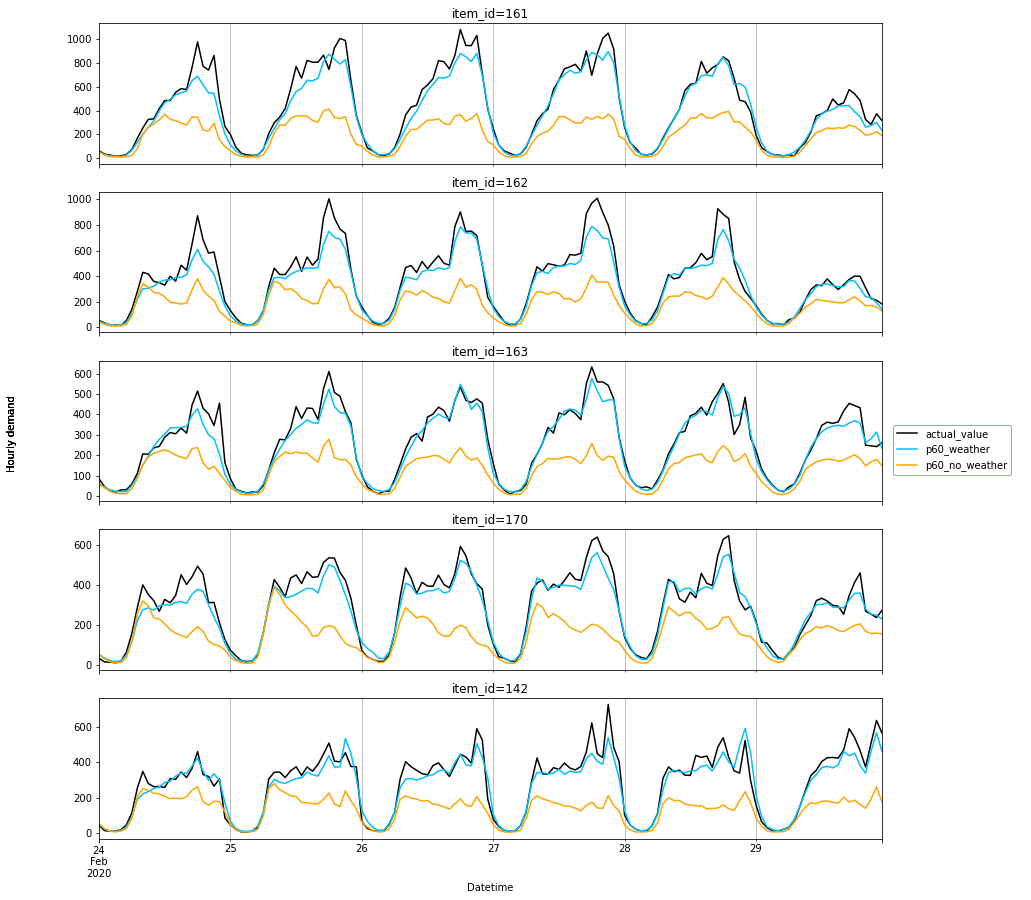

In [51]:
## VISUALIZE BASE AND WEATHER FORECASTS


# Note to self: if plot below shows in scrolling window, select Cell > Current Outputs > Toggle scrolling
# np.warnings.filterwarnings('ignore')  
fig, axs = plt.subplots(len(random_items), 1, figsize=(15, 15), sharex=True)

# Adjust the scaling factor to fit your legend text completely outside the plot
# (smaller value results in more space being made for the legend)
plt.subplots_adjust(right=0.85)

# select backtest window range when there was a weather event
zoomed = df_plot.copy()
zoomed = zoomed.loc["2020-02-24":"2020-02-29"].copy()


for i in range(len(random_items)):
    
    item = random_items[i]
    zoomed2 = zoomed.loc[(zoomed[item_id]==item), :].copy()

    zoomed2[['actual_value']].plot(ax=axs[i], color='k')
    colors = ['mediumpurple', 'orange', 'deepskyblue']
    
    zoomed2[[f"{winning_quantile}_weather"]].plot(ax=axs[i], color=colors[2])
    zoomed2[[f"{winning_quantile}_no_weather"]].plot(ax=axs[i], color=colors[1])
    
    axs[i].set_title(f"item_id={item}")  
    # set common Y label 
    fig.text(0.04, 0.5, 'Hourly demand', va='center', rotation='vertical')
    
    # format the x ticks
    axs[i].set_xlabel("Datetime")   
    
    # remove each individual subplot legend
    axs[i].get_legend().remove()
    # create single legend outside plot and show only 1x
    if i == 0:
        fig.legend(loc="center right",
            edgecolor='g', framealpha=0.5,
            borderaxespad=2)
        
    # format the grid
    axs[i].grid(False)
    axs[i].grid(which='minor', axis='x')
    
plt.plot();

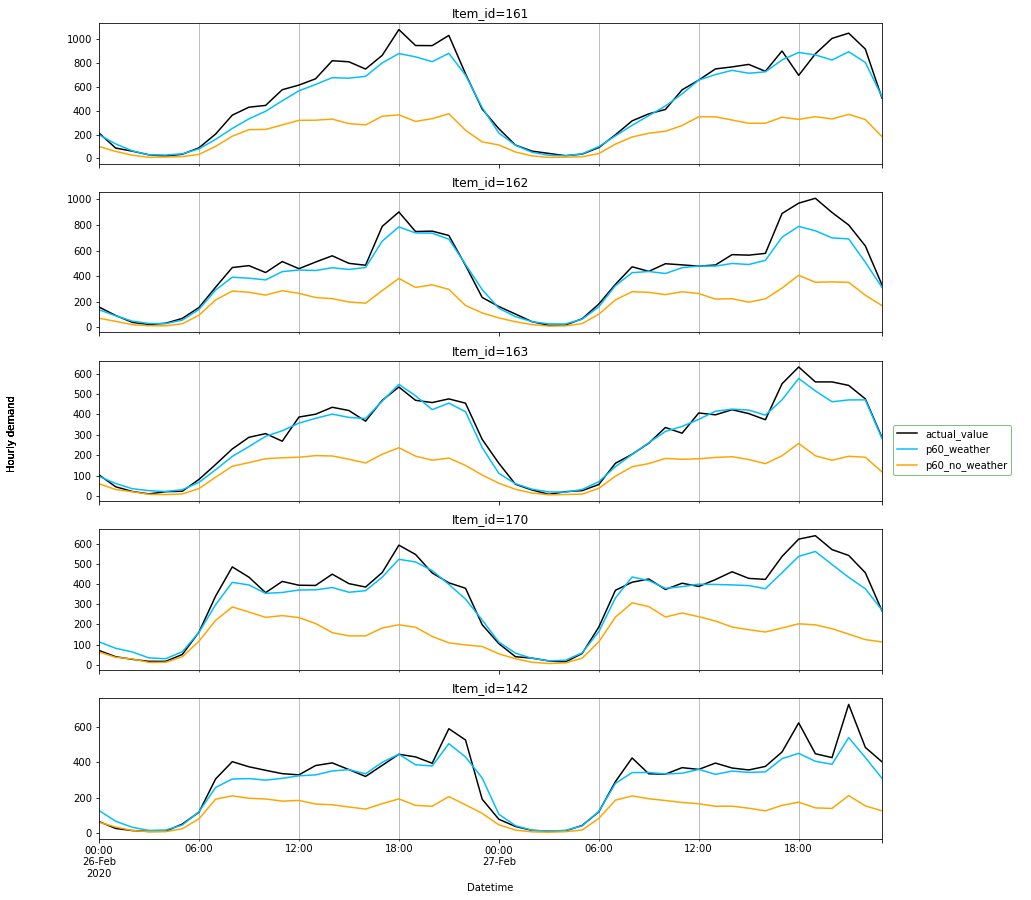

In [52]:
# Visualize items - zoom in to see hours

fig, axs = plt.subplots(len(random_items), 1, figsize=(15, 15), sharex=True)

# Adjust the scaling factor to fit your legend text completely outside the plot
# (smaller value results in more space being made for the legend)
plt.subplots_adjust(right=0.85)

# select backtest window range when there was a weather event
zoomed = df_plot.copy()
zoomed = zoomed.loc["2020-02-26":"2020-02-27"].copy()


for i in range(len(random_items)):
    
    item = random_items[i]
    zoomed2 = zoomed.loc[(zoomed[item_id]==item), :]

    zoomed2[['actual_value']].plot(ax=axs[i], color='k')
    colors = ['mediumpurple', 'orange', 'deepskyblue']
    
    zoomed2[[f"{winning_quantile}_weather"]].plot(ax=axs[i], color=colors[2])
    zoomed2[[f"{winning_quantile}_no_weather"]].plot(ax=axs[i], color=colors[1])
    
    axs[i].set_title(f"Item_id={item}")  
    # set common Y label instead 
    fig.text(0.04, 0.5, 'Hourly demand', va='center', rotation='vertical')
    
    # format the x ticks
    axs[i].set_xlabel("Datetime")   
    
    # remove each individual subplot legend
    axs[i].get_legend().remove()
    # create single legend outside plot and show only 1x
    if i == 0:
        fig.legend(loc="center right",
            edgecolor='g', framealpha=0.5,
            borderaxespad=2)
        
    # format the grid
    axs[i].grid(False)
    axs[i].grid(which='minor', axis='x')

plt.plot();


For more details about item-level accuracy metrics see blogs and notebook/
<ul>
    <li><a href="https://aws.amazon.com/blogs/machine-learning/measuring-forecast-model-accuracy-to-optimize-your-business-objectives-with-amazon-forecast/", target="_blank">Ability to use custom quantiles in Amazon Forecast AutoML Training</a></li>
        <li><a href="https://aws.amazon.com/blogs/machine-learning/amazon-forecast-now-supports-accuracy-measurements-for-individual-items/", target="_blank">Ability to export Predictor Backtest Files to evaluate Item-level accuracy from Amazon Forecast Training step.</a></li>
    </ul>
    
For now, we'll calculate overall Weighted Quantile Loss (wQL) for the Weather and No Weather models.  Then we'll decide which model to deploy based on which model has lowest wQL.  

In Amazon Forecast, "deploying a model" means generate Forecasts from the selected Predictor model.

In [54]:
### CALCULATE WQL FOR THE NO WEATHER MODEL

metrics = df_no_weather.loc[(df_no_weather.item_id.isin(top_moving_items)), :].copy()
all_items = metrics.item_id.unique()
g = metrics.groupby([item_id]).sum()
metrics = g.copy()
metrics = metrics.reset_index(inplace=True)

for q in quantile_cols:
    # parse the quantile
    if q == "mean":
        len_quantile_cols = len(quantile_cols) - 1
        continue #skip mean since it's not a quantile
    else:
        quantile = pd.to_numeric(q.split('p')[1]) / 100
    
    agg = pd.DataFrame()
    for i in all_items:
        temp = g.copy()
        temp.reset_index(inplace=True)
        temp = temp.loc[(temp.item_id==i), :]

        # wql at item level
        temp[f"wql_weather_{q}"] = calc_quantile_loss(temp[target_value]
                                         , temp[q]
                                         , quantile)
        agg = pd.concat([agg, temp], axis=0)

    # align indexes for low memory merging
    agg.set_index([item_id], inplace=True)
    metrics = pd.concat([metrics, agg[[f"wql_weather_{q}"]]], axis=1) # join='inner'

# metrics.drop(quantile_cols, axis=1, inplace=True)
print(metrics.shape)

# Show mean wQL for all top-selling items
np.mean(metrics)

(47, 3)


wql_weather_p50    0.133867
wql_weather_p60    0.106327
wql_weather_p70    0.055778
dtype: float64

In [55]:
### CALCULATE WQL FOR THE WEATHER MODEL

metrics = df.loc[(df.velocity=="top"), :].copy()
all_items = metrics.item_id.unique()
g = metrics.groupby([item_id]).sum()
metrics = g.copy()
metrics = metrics.reset_index(inplace=True)

for q in quantile_cols:
    # parse the quantile
    if q == "mean":
        len_quantile_cols = len(quantile_cols) - 1
        continue #skip mean since it's not a quantile
    else:
        quantile = pd.to_numeric(q.split('p')[1]) / 100
    
    agg = pd.DataFrame()
    for i in all_items:
        temp = g.copy()
        temp.reset_index(inplace=True)
        temp = temp.loc[(temp.item_id==i), :]

        # wql at item level
        temp[f"wql_weather_{q}"] = calc_quantile_loss(temp[target_value]
                                         , temp[q]
                                         , quantile)
        agg = pd.concat([agg, temp], axis=0)

    # align indexes for low memory merging
    agg.set_index([item_id], inplace=True)
    metrics = pd.concat([metrics, agg[[f"wql_weather_{q}"]]], axis=1) # join='inner'

# metrics.drop(quantile_cols, axis=1, inplace=True)
print(metrics.shape)

# Show mean wQL for all top-selling items
np.mean(metrics)

# Compare to no-weather wQLs
# wql_weather_p50    0.133867
# wql_weather_p60    0.106327
# wql_weather_p70    0.055778

(47, 3)


wql_weather_p50    0.047876
wql_weather_p60    0.025373
wql_weather_p70    0.030803
dtype: float64

Since the weather model has lowest Weighted Quantile Loss (wQL), we would select the Weather Index Predictor and create Forecasts from that predictor.

We'll skip this step for now.  You can see examples how to create forecasts, query, and delete forecasts by API calls in other sample notebooks, for example 
<li><a href="https://github.com/aws-samples/amazon-forecast-samples/blob/master/notebooks/advanced/Incorporating_Related_Time_Series_dataset_to_your_Predictor/Incorporating_Related_Time_Series_dataset_to_your_Predictor.ipynb", target="_blank">Amazon forecast notebook using related time series</a>
</li>
<br>

# Step 6. Cleaning up your Resources<a class="anchor" id="cleanup">

Once we have completed the above steps, we can start to cleanup the resources we created. All delete jobs, except for `delete_dataset_group` are asynchronous, so we have added the helpful `wait_till_delete` function. 
Resource Limits documented <a href="https://docs.aws.amazon.com/forecast/latest/dg/limits.html">here</a>. 

In [ ]:
# Delete Backtest Export File jobs for both algorithms

util.wait_till_delete(lambda: \
                 forecast.delete_predictor_backtest_export_job(
                    PredictorBacktestExportJobArn = backtest_export_job_arn_deepar_weather)
                )
util.wait_till_delete(lambda: \
                 forecast.delete_predictor_backtest_export_job(
                    PredictorBacktestExportJobArn = backtest_export_job_arn_deepar_no_weather)
                )

In [ ]:
# Delete predictors
util.wait_till_delete(lambda: forecast.delete_predictor(PredictorArn = predictor_arn_deepar_weather))
util.wait_till_delete(lambda: forecast.delete_predictor(PredictorArn = predictor_arn_deepar_no_weather))

In [ ]:
# Delete the target time series import job
util.wait_till_delete(lambda: forecast.delete_dataset_import_job(DatasetImportJobArn=ts_dataset_import_job_arn))

In [ ]:
# Delete the target time series datasets
util.wait_till_delete(lambda: forecast.delete_dataset(DatasetArn=ts_dataset_arn))

In [ ]:
# Delete dataset group
forecast.delete_dataset_group(DatasetGroupArn=dataset_group_arn)

In [ ]:
# # Delete IAM role
# util.delete_iam_role( role_name )